In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install nltk==3.4

     |████████████████████████████████| 1.4MB 3.8MB/s 
  Created wheel for nltk: filename=nltk-3.4-cp37-none-any.whl size=1436401 sha256=9237941f196f8ec632ef7eb56ba6102f7807b02deddfe00f28bcf7d79ffc160b
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import os

base_path = 'gdrive/MyDrive/TSAI_END2/Session7/Assignment1'
out_path = os.path.join('gdrive/MyDrive/TSAI_END2/Session5/data/', 'sst_{}.txt')
sst_path = 'gdrive/MyDrive/TSAI_END2/Session5/stanfordSentimentTreebank'

## Dataset
---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download these NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk, time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import collections, itertools

In [ ]:
import numpy as np
import pandas as pd

class SST():
  def __init__(self, sst_path):
    self.ranges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    self.labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
    self.label = [0, 1, 2, 3, 4]

    self.sst_sents = pd.read_csv(os.path.join(sst_path, 'datasetSentences.txt'), delimiter='\t')
    self.sst_phrases = pd.read_csv(os.path.join(sst_path, 'dictionary.txt'), delimiter='|', names=['phrase','phrase_id'])
    self.sst_labels  = pd.read_csv(os.path.join(sst_path, 'sentiment_labels.txt'), delimiter='|')
  
  def extract(self):
    sst_sentences_phrases = pd.merge(self.sst_sents, self.sst_phrases, how='inner', left_on=['sentence'], right_on=['phrase'])
    sst = pd.merge(sst_sentences_phrases, self.sst_labels, how='inner', left_on=['phrase_id'], right_on=['phrase ids'])[['sentence','sentiment values']]
    sst['labels'] = pd.cut(sst['sentiment values'], bins=self.ranges, labels=self.labels, include_lowest=True)
    sst_data = sst[['sentence', 'labels']]

    return sst_data

In [ ]:
# Read data
sst_df = SST(sst_path).extract()

print('Sample SST data:')
print(sst_df.head())
print(f'Data Size: {len(sst_df)}')

Sample SST data:
                                            sentence         labels
0  The Rock is destined to be the 21st Century 's...       positive
1  The gorgeously elaborate continuation of `` Th...  very positive
2                     Effective but too-tepid biopic        neutral
3  If you sometimes like to go to the movies to h...       positive
4  Emerges as something rare , an issue movie tha...  very positive
Data Size: 11286


In [ ]:
# Function to tokenize the tweets
def custom_tokenize(text):
    """Function that tokenizes text"""
    from nltk.tokenize import word_tokenize
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return word_tokenize(text)

# Function that applies the cleaning steps
def clean_up(data1):
    """Function that cleans up the data into a shape that can be further used for modeling"""
    data = data1.copy()
    tokenized = data['sentence'].apply(custom_tokenize) # Tokenize tweets
    lower_tokens = tokenized.apply(lambda x: [t.lower() for t in x]) # Convert tokens into lower case
    alpha_only = lower_tokens.apply(lambda x: [t for t in x if t.isalpha()]) # Remove punctuations
    no_stops = alpha_only.apply(lambda x: [t for t in x if t not in stopwords.words('english')]) # remove stop words
    data['cleaned_text'] = no_stops
    return data

In [ ]:
sst_df_cleaned = clean_up(sst_df)

In [ ]:
print('Sample cleaned SST data:')
print(sst_df_cleaned.head())
print(f' Data Size: {len(sst_df_cleaned)}')

Sample cleaned SST data:
                                            sentence  ...                                       cleaned_text
0  The Rock is destined to be the 21st Century 's...  ...  [rock, destined, century, new, conan, going, m...
1  The gorgeously elaborate continuation of `` Th...  ...  [gorgeously, elaborate, continuation, lord, ri...
2                     Effective but too-tepid biopic  ...                                [effective, biopic]
3  If you sometimes like to go to the movies to h...  ...  [sometimes, like, go, movies, fun, wasabi, goo...
4  Emerges as something rare , an issue movie tha...  ...  [emerges, something, rare, issue, movie, hones...

[5 rows x 3 columns]
 Data Size: 11286


## Dataset Creation
---

In [ ]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 42
torch.manual_seed(SEED)

In [ ]:
Text = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =True)

fields = [('text', Text),('label',Label)]
example = [data.Example.fromlist([sst_df.sentence[i],sst_df.labels[i]], fields) for i in range(sst_df.shape[0])] 

# Creating dataset
SSTDataset = data.Dataset(example, fields)

(train_data, test_data) = SSTDataset.split(split_ratio=[0.7, 0.3], random_state=random.seed(SEED))

In [ ]:
(len(train_data), len(test_data))

(7900, 3386)

In [ ]:
vars(train_data.examples[10])

{'label': 'very positive',
 'text': ['If',
  'you',
  'dig',
  'on',
  'David',
  'Mamet',
  "'s",
  'mind',
  'tricks',
  '...',
  'rent',
  'this',
  'movie',
  'and',
  'enjoy',
  '!']}

In [ ]:
# Text.build_vocab(train)
# Label.build_vocab(train)

MAX_VOCAB_SIZE = 25_000

Text.build_vocab(train_data,  
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

Label.build_vocab(train_data)

In [ ]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16404
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7441), (',', 6576), ('the', 5603), ('of', 4119), ('and', 4091), ('a', 4049), ('to', 2773), ('-', 2538), ('is', 2314), ("'s", 2286)]
Labels :  defaultdict(None, {'negative': 0, 'positive': 1, 'neutral': 2, 'very positive': 3, 'very negative': 4})


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_iterator, test_iterator = data.BucketIterator.splits((train_data, test_data), batch_size = 64, 
                                                            sort_key = lambda x: len(x.text), sort=False,shuffle=True,
                                                            sort_within_batch=True, device = device)

In [ ]:
import os, pickle
with open(os.path.join(base_path, 'glove_sst_sentence_tokenizer.pkl'), 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

with open(os.path.join(base_path, 'sst_label.pkl'), 'wb') as tokens: 
    pickle.dump(Label.vocab.stoi, tokens)

## Model Building
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        # Constructor
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        # activation function
        self.act = nn.Softmax() #\ F.log_softmax(outp)

    def forward(self, text, text_lengths):
        # text = [batch size,sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True) # unpad

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # packed_output shape = (batch, seq_len, num_directions * hidden_size)
        # hidden shape  = (num_layers * num_directions, batch, hidden_size)

        # concat the final forward and backward hidden state
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # output, output_lengths = pad_packed_sequence(packed_output)  # pad the sequence to the max length in the batch

        rel = self.relu(cat)
        dense1 = self.fc1(rel)

        drop = self.dropout(dense1)
        preds = self.fc2(drop)

        return preds

In [ ]:
# Define hyperparameters
size_of_vocab = len(Text.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = len(Label.vocab)
num_layers = 2
dropout = 0.2
PAD_IDX = Text.vocab.stoi[Text.pad_token]

hidden_dim2 = 128
bi_directional = True

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, hidden_dim2, num_output_nodes, num_layers, bi_directional, dropout = dropout, pad_index=PAD_IDX)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16404, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softmax(dim=None)
)
The model has 4,016,853 trainable parameters


In [ ]:
pretrained_embeddings = Text.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.2805,  0.1506,  0.3955,  ...,  0.6393,  0.0779,  0.7722],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [ 0.8964, -1.2446,  0.4262,  ..., -1.1711,  0.7639,  0.5323]])

In [ ]:
UNK_IDX = Text.vocab.stoi[Text.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

## Model Training
---

In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# define metric
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        text, text_lengths = batch.text   
        
        # convert to 1D tensor
        predictions = model(text, text_lengths)
        # print(predictions.shape)
        # print(batch.label.shape)
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the categorical accuracy
        acc = categorical_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.text   
            
            # convert to 1D tensor
            predictions = model(text, text_lengths).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(base_path, 'saved_weights.pt'))
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

torch.save(model.state_dict(), os.path.join(base_path, 'ep10_saved_weights.pt'))

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.513 | Train Acc: 32.41%
	 Val. Loss: 1.450 |  Val. Acc: 37.15% 

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.330 | Train Acc: 41.18%
	 Val. Loss: 1.354 |  Val. Acc: 40.87% 

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 1.171 | Train Acc: 47.44%
	 Val. Loss: 1.342 |  Val. Acc: 41.35% 

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.996 | Train Acc: 56.11%
	 Val. Loss: 1.425 |  Val. Acc: 40.87% 

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.796 | Train Acc: 67.04%
	 Val. Loss: 1.660 |  Val. Acc: 37.96% 

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.597 | Train Acc: 76.47%
	 Val. Loss: 2.035 |  Val. Acc: 39.62% 

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.413 | Train Acc: 84.35%
	 Val. Loss: 2.526 |  Val. Acc: 38.83% 

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.280 | Train Acc: 89.69%
	 Val. Loss: 2.906 |  Val. Acc: 38.91% 

Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.164 | Train Acc: 94.12%
	 Val. Loss: 3.431 |  Val. Acc: 38.06% 

Epoch: 10 

## Visualization
---

In [ ]:
# visualize accuracy and loss graph
def visualize_graph(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

def visualize_save_train_vs_test_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  #epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    x = np.linspace(1, EPOCHS+1, len(item))
    plt.plot(x, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/"+name+".png")

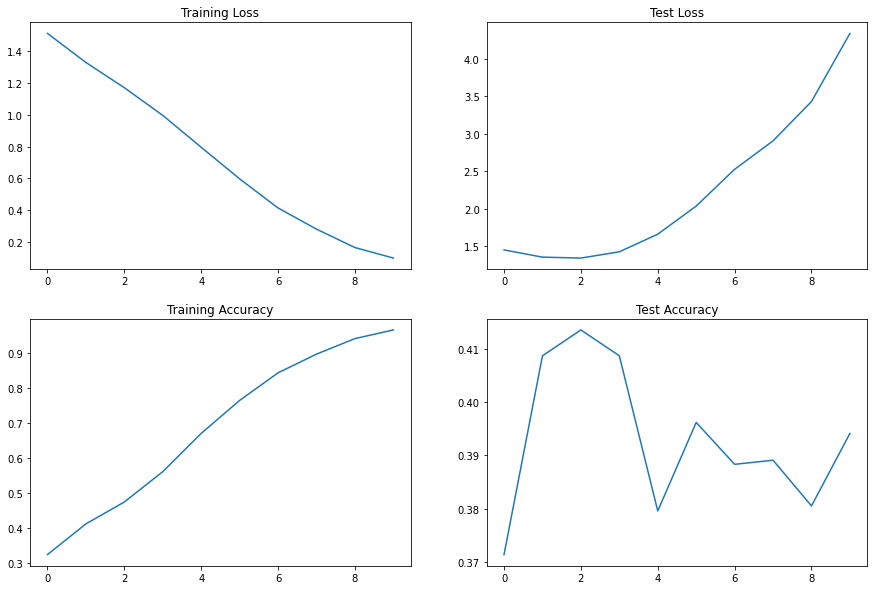

In [ ]:
visualize_graph(train_losses, train_accs, valid_losses, valid_accs)

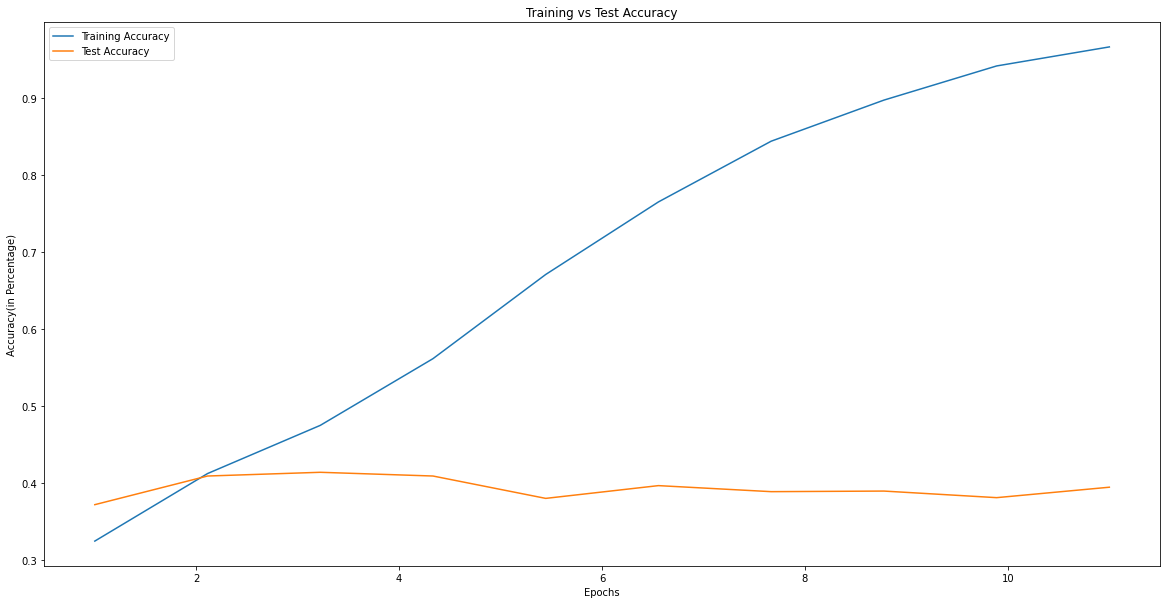

In [ ]:
dict_list = {'Training Accuracy': train_accs, 'Test Accuracy': valid_accs}
title = "Training vs Test Accuracy"
xlabel = "Epochs"
ylabel = "Accuracy(in Percentage)"
name = "train_vs_test_acc_comparison_graph"

visualize_save_train_vs_test_graph(N_EPOCHS, dict_list, title, xlabel, ylabel, base_path, name=name)

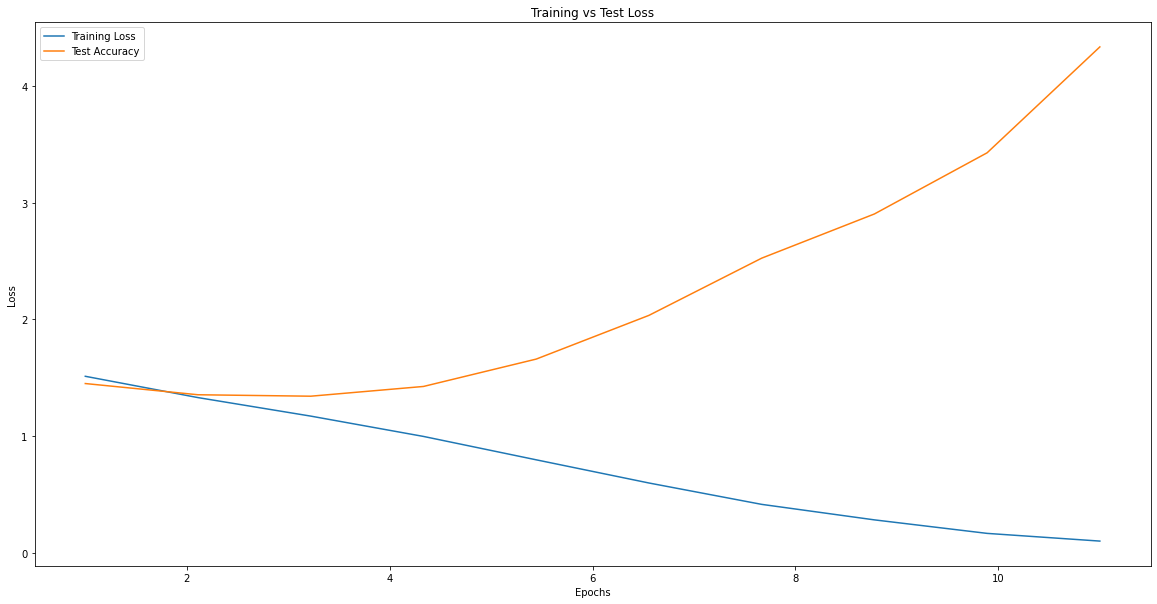

In [ ]:
dict_list = {'Training Loss': train_losses, 'Test Accuracy': valid_losses}
title = "Training vs Test Loss"
xlabel = "Epochs"
ylabel = "Loss"
name = "train_vs_test_loss_comparison_graph"

visualize_save_train_vs_test_graph(N_EPOCHS, dict_list, title, xlabel, ylabel, base_path, name=name)

## Evaluation
---

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, 
                          classes=['Very Negative','Negative','Neutral','Positive','Very Positive'],#[1, 2, 3, 4, 5],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

In [ ]:
#load weights and tokenizer
import pickle

# path='gdrive/MyDrive/TSAI_END2/Session5/saved_weights.pt'
# model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open(os.path.join(base_path, 'glove_sst_sentence_tokenizer.pkl'), 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_text(text):
    
    categories = {0:'very negative', 1:'negative', 2:'neutral', 3:'positive', 4:'very positive'}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(text)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    # _, pred = torch.max(prediction, 1) 
    pred = prediction.argmax(1, keepdim = True)
    
    return categories[pred.item()]

In [ ]:
def evaluation_pred(model, iterator):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    eval_df = pd.DataFrame(columns=['label','pred'])
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.text 
            label = batch.label.cpu().numpy()  
            
            # convert to 1D tensor
            predictions = model(text, text_lengths)
            top_pred = predictions.argmax(1, keepdim = True).cpu().numpy()
            batch_df = pd.DataFrame(top_pred, columns=['pred'])
            batch_df['label'] = label
            batch_df['pred'] = batch_df['pred'].astype(int)
            batch_df['label'] = batch_df['label'].astype(int)
            eval_df = pd.concat([eval_df, batch_df])          
        
    return eval_df

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def print_accuracy(df, target_col, pred_column):
    "Print f1 score and accuracy after making predictions"
    f1_macro = f1_score(df[target_col].astype(int), df[pred_column].astype(int), average='macro')
    acc = accuracy_score(df[target_col].astype(int), df[pred_column].astype(int))*100
    return f1_macro, acc

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

In [ ]:
eval_df = evaluation_pred(model, test_iterator)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f424e307990>)

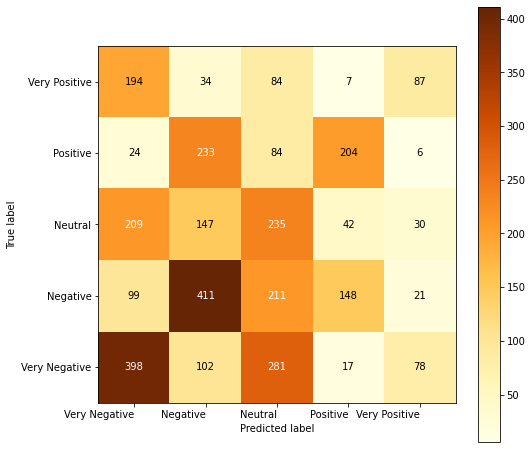

In [ ]:
plot_confusion_matrix(eval_df['label'].values.tolist(), eval_df['pred'].values.tolist())

In [ ]:
f1_macro, acc = print_accuracy(eval_df, 'label', 'pred')
print(f'F1 Macro Score: {f1_macro}')
print(f'Accuracy: {acc} %')

F1 Macro Score: 0.37888155595873435
Accuracy: 39.42705256940343 %


In [ ]:
# model.load_state_dict(torch.load(os.path.join(base_path, 'ep10_saved_weights.pt')))
# model = model.to(device)

In [ ]:
# SentimentClass = {0:'Very Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Very Positive'}
sst_df['pred'] = sst_df['sentence'].apply(classify_text)

In [ ]:
correctly_classified_texts = sst_df[sst_df['labels'] == sst_df['pred']][:20]
print("*"*40)
print("***** Correctly Classified Text: *******")
print("*"*40)
for i, (index, row) in enumerate(correctly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['sentence']}")
  print(f"   Target Sentiment: {row['labels']}")
  print(f"   Predicted Sentiment: {row['pred']}")
  print()

****************************************
***** Correctly Classified Text: *******
****************************************
1) Text: Effective but too-tepid biopic
   Target Sentiment: neutral
   Predicted Sentiment: neutral

2) Text: The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
   Target Sentiment: neutral
   Predicted Sentiment: neutral

3) Text: Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .
   Target Sentiment: positive
   Predicted Sentiment: positive

4) Text: Ultimately , it ponders the reasons we need stories so much .
   Target Sentiment: neutral
   Predicted Sentiment: neutral

5) Text: Illuminating if overly talky documentary .
   Target Sentiment: neutral
   Predicted Sentiment: neutral

6) Text: Light , cute and forgettable .
   Target Sentiment: neutral
   Predicted Sentiment: neutral

7) Text: Cantet perfectly captures

In [ ]:
incorrectly_classified_texts = sst_df[sst_df['labels'] != sst_df['pred']][:10]
print("*"*40)
print("***** Incorrectly Classified Text: *****")
print("*"*40)
for i, (index, row) in enumerate(incorrectly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['sentence']}")
  print(f"   Target Sentiment: {row['labels']}")
  print(f"   Predicted Sentiment: {row['pred']}")
  print()

****************************************
***** Incorrectly Classified Text: *****
****************************************
1) Text: The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
   Target Sentiment: positive
   Predicted Sentiment: negative

2) Text: The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
   Target Sentiment: very positive
   Predicted Sentiment: positive

3) Text: If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .
   Target Sentiment: positive
   Predicted Sentiment: negative

4) Text: Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .
   Target Sentiment: very posi